In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
ctype = 'cd8'
datadir = f'/data/leslie/shared/ASA/mouseASA/{ctype}/human/'

In [3]:
import pandas as pd
import numpy as np
df = pd.read_csv(datadir+'human_JP_CD8_data.csv')

In [4]:
from utils import one_hot
idx = np.where(np.array([len(x) for x in df['seq_alt']])==300)[0]    #pick only the ones with 300bp input
x_ref = one_hot(list(df['seq_ref'][idx]))
x_alt = one_hot(list(df['seq_alt'][idx]))

In [105]:
import torch
from model import alleleScan

model = alleleScan(2, 0.2)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

basedir = f'/data/leslie/shared/ASA/mouseASA/{ctype}/cast'
dataset = 'trueref'
use_prior = '1'
weight = '1.0'
gc = ''
modelname = 'm3'
batchsize = '32'
ident = '_vi_150bp_aug'

SAVEPATH = f'{basedir}/ckpt_models/{modelname}_{dataset}_{batchsize}_{weight}{gc}{ident}.hdf5'
print(SAVEPATH)
model.load_state_dict(torch.load(SAVEPATH))
model.to(DEVICE)
model.eval()
pred_ref = []
pred_alt = []
for i in range(0, len(x_ref), int(batchsize)):
    pred_ref.append(model(torch.from_numpy(x_ref[i:i+int(batchsize)]).type(torch.FloatTensor).transpose(1,2).to(DEVICE)).detach().cpu().numpy())
    pred_alt.append(model(torch.from_numpy(x_alt[i:i+int(batchsize)]).type(torch.FloatTensor).transpose(1,2).to(DEVICE)).detach().cpu().numpy())
pred_ref = np.concatenate(pred_ref)
pred_alt = np.concatenate(pred_alt)

/data/leslie/shared/ASA/mouseASA/cd8/cast/ckpt_models/m3_trueref_32_1.0_vi_150bp_aug.hdf5


In [102]:
import torch
from model import pairScan, pairScanWrapper

model = pairScan(2, 0.2)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

basedir = f'/data/leslie/shared/ASA/mouseASA/{ctype}/cast'
dataset = 'both'
use_prior = '1'
weight = '1.0'
gc = ''
modelname = 'ad'
batchsize = '32'
ident = '_vi_150bp_aug'

SAVEPATH = f'{basedir}/ckpt_models/{modelname}_{dataset}_{batchsize}_{weight}{gc}{ident}.hdf5'
print(SAVEPATH)
model.load_state_dict(torch.load(SAVEPATH))
supermodel = pairScanWrapper(model)
supermodel.to(DEVICE)
supermodel.eval()
temp = np.stack((x_ref, x_alt), axis=1)
preds = supermodel(torch.from_numpy(temp).type(torch.FloatTensor).transpose(2,3).to(DEVICE)).detach().cpu().numpy().reshape(-1,2)
pred_ref = preds[:,0]
pred_alt = preds[:,1]

/data/leslie/shared/ASA/mouseASA/cd8/cast/ckpt_models/ad_both_32_1.0_vi_150bp_aug.hdf5


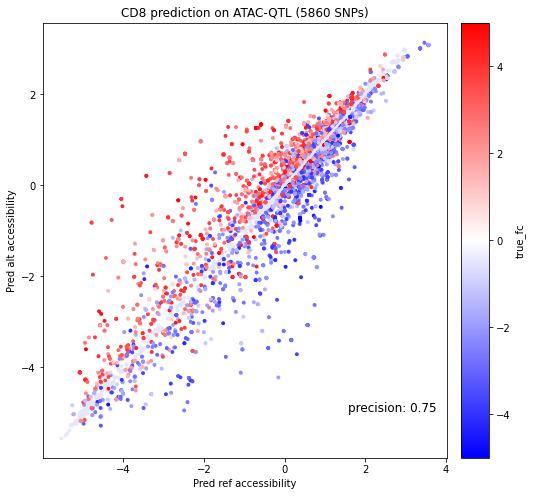

In [106]:
# Classification performance of mouse model on human ATAC QTLs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
pred_fc = pred_alt - pred_ref
true_fc = np.log2((1+df['altCount'][idx])/(1+df['refCount'][idx]))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

ax.scatter(pred_ref, pred_alt, s = 8, c = 'lavender')
sc = ax.scatter(pred_ref[abs(pred_fc)>0.1],
           pred_alt[abs(pred_fc)>0.1], c = true_fc[abs(pred_fc)>0.1],
            vmax = 5, vmin = -5, cmap = 'bwr', s = 8)

plt.title('CD8 prediction on ATAC-QTL ({} SNPs)'.format(len(pred_fc)))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="7%", pad=0.2,)
fig.colorbar(sc, cax=cax)
ax.set_xlabel('Pred ref accessibility')
ax.set_ylabel('Pred alt accessibility')
plt.ylabel('true_fc')

temp1 = (pred_fc[abs(pred_fc)>0.1]*true_fc[abs(pred_fc)>0.1]) > 0
prec = sum(temp1)/len(temp1)
plt.text(-4, -4, 'precision: {:.2f}'.format(prec), 
         ha='left', va='bottom',fontsize=12)
plt.show()

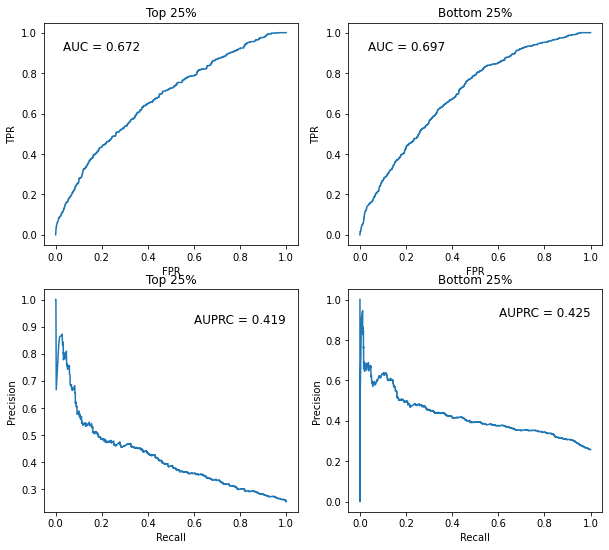

In [111]:
from utils import plot_auc

p = 25
fig, ax = plt.subplots(2,2, figsize=(10,9))
plot_auc((true_fc > np.percentile(true_fc,100 - p))*1, 1*pred_fc, 'roc', ax[0,0])
ax[0,0].set_title(f'Top {p}%')
plot_auc((true_fc < np.percentile(true_fc,p))*1, -1*pred_fc, 'roc', ax[0,1])
ax[0,1].set_title(f'Bottom {p}%')
plot_auc((true_fc > np.percentile(true_fc,100 - p))*1, 1*pred_fc, 'prc', ax[1,0])
ax[1,0].set_title(f'Top {p}%')
plot_auc((true_fc < np.percentile(true_fc,p))*1, -1*pred_fc, 'prc', ax[1,1])
ax[1,1].set_title(f'Bottom {p}%')
plt.show()

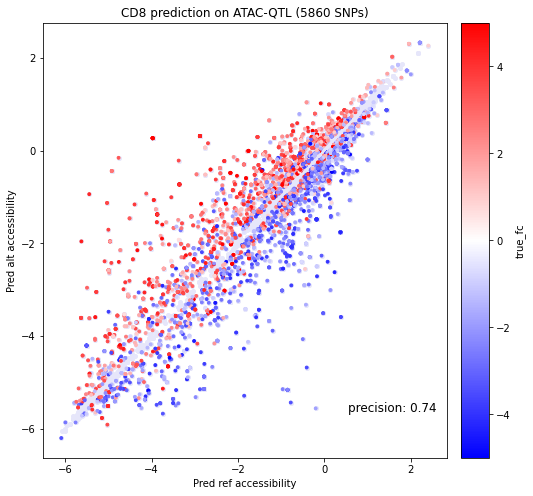

In [108]:
# Compare with results from the Jonathan Pritchard paper
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
pred_fc = df['pred_alt'][idx]-df['pred_ref'][idx]
true_fc = np.log2((1+df['altCount'][idx])/(1+df['refCount'][idx]))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

ax.scatter(df['pred_ref'][idx], df['pred_alt'][idx], s = 16, c = 'lavender')
sc = ax.scatter(df['pred_ref'][idx][abs(pred_fc)>0.1],
           df['pred_alt'][idx][abs(pred_fc)>0.1], c = true_fc[abs(pred_fc)>0.1],
            vmax = 5, vmin = -5, cmap = 'bwr', s = 8)

plt.title('CD8 prediction on ATAC-QTL ({} SNPs)'.format(len(pred_fc)))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="7%", pad=0.2,)
fig.colorbar(sc, cax=cax)
ax.set_xlabel('Pred ref accessibility')
ax.set_ylabel('Pred alt accessibility')
plt.ylabel('true_fc')

temp1 = (pred_fc[abs(pred_fc)>0.1]*true_fc[abs(pred_fc)>0.1]) > 0
prec = sum(temp1)/len(temp1)
plt.text(-4, -4, 'precision: {:.2f}'.format(prec), 
         ha='left', va='bottom',fontsize=12)
plt.show()